In [3]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [4]:
from astropy.table import Table
mock = Table()

dirname = "/Volumes/simulation_data_2018/protoDC2_v4p6_lf_calibration_data/individual_columns_v4p5"
import os
basename = "{0}_v4.5.npy"
mock['redshift'] = np.load(os.path.join(dirname, basename.format('redshift')))
mock['mstar'] = np.load(os.path.join(dirname, basename.format('mstar')))
mock['mag_r'] = np.load(os.path.join(dirname, basename.format('mag_r')))
mock['mag_g_obs'] = np.load(os.path.join(dirname, basename.format('mag_g_obs')))
mock['mag_r_obs'] = np.load(os.path.join(dirname, basename.format('mag_r_obs')))
mock['mag_i_obs'] = np.load(os.path.join(dirname, basename.format('mag_i_obs')))
mock['upid'] = np.load(os.path.join(dirname, basename.format('upid')))
mock['mag_r_kcorrect'] = mock['mag_r_obs'] - mock['mag_r']


## Experiment with three different $\langle M_{\rm r}\ \vert\ M_{\ast} \rangle$ relations

In [90]:
from cosmodc2.sdss_colors.new_analytical_magr import median_magr_from_mstar

npts = int(1e3)
mstar = np.logspace(5.8, 12.5, npts)
upid = np.zeros_like(mstar) - 1

### default relation used in v4.5
mr_z0p0 = median_magr_from_mstar(mstar, upid, 0.0)
mr_z0p25 = median_magr_from_mstar(mstar, upid, 0.25)
mr_z0p5 = median_magr_from_mstar(mstar, upid, 0.5)
mr_z0p75 = median_magr_from_mstar(mstar, upid, 0.75)
mr_z1p0 = median_magr_from_mstar(mstar, upid, 1.0)

### new relation for in v4.6a
kwargs_alt = dict(normalization_boost_table=(0, 0, 0, 0),
                 gamma_z_table=[0.0, 0.25, 0.5, 1.], 
                  gamma_boost_table=[0.0, 0.0, -0.25, -0.5])
kwargs_alt = {'gamma_z0': 2.75, 'beta_z0': 2.513, 'm1': 10.5, 'magr_at_m1_z0': -21.036}

mr_z0p0_alt = median_magr_from_mstar(mstar, upid, 0.0, **kwargs_alt)
mr_z0p25_alt = median_magr_from_mstar(mstar, upid, 0.25, **kwargs_alt)
mr_z0p5_alt = median_magr_from_mstar(mstar, upid, 0.5, **kwargs_alt)
mr_z0p75_alt = median_magr_from_mstar(mstar, upid, 0.75, **kwargs_alt)
mr_z1p0_alt = median_magr_from_mstar(mstar, upid, 1.0, **kwargs_alt)

### new relation for in v4.6b
kwargs_alt2 = dict(normalization_boost_table=(0, 0, 0, 0),
                 gamma_z_table=[0.0, 0.25, 0.5, 1.], 
                  gamma_boost_table=[0.0, 0.0, -0.25, -0.5])
kwargs_alt2 = {'gamma_z0': 3.5, 'beta_z0': 2.513, 'm1': 10.5, 'magr_at_m1_z0': -21.036}

mr_z0p0_alt2 = median_magr_from_mstar(mstar, upid, 0.0, **kwargs_alt2)
mr_z0p25_alt2 = median_magr_from_mstar(mstar, upid, 0.25, **kwargs_alt2)
mr_z0p5_alt2 = median_magr_from_mstar(mstar, upid, 0.5, **kwargs_alt2)
mr_z0p75_alt2 = median_magr_from_mstar(mstar, upid, 0.75, **kwargs_alt2)
mr_z1p0_alt2 = median_magr_from_mstar(mstar, upid, 1.0, **kwargs_alt2)


In [91]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [119]:
# def magr(mstar, upid, m1, magr_at_m1_z0, gamma, beta, dm1=0.15):
#     mstar = np.atleast_1d(mstar)
#     x = mstar/10**m1
#     logsm = np.log10(mstar)
#     logx = np.log10(x)

#     slope = np.zeros_like(logx)
#     low_mass_mask = logsm < m1 - dm1
#     mid_mass_mask = (logsm >= m1-dm1) & (logsm < m1+dm1)
#     high_mass_mask = logsm >= m1 + dm1

#     slope[low_mass_mask] = gamma
#     slope[mid_mass_mask] = np.interp(
#         logsm[mid_mass_mask], [m1-dm1, m1+dm1], [gamma, beta])
#     slope[high_mass_mask] = beta
#     result = -slope*logx + magr_at_m1_z0
#     return result

def magr(mstar, upid, m1, magr_at_m1_z0, gamma, beta, dm1=0.15):
    mstar = np.atleast_1d(mstar)
    x = mstar/10**m1
    logsm = np.log10(mstar)
    logx = np.log10(x)

    slope = np.zeros_like(logx)
    low_mass_mask = logsm < m1 - dm1
    mid_mass_mask = (logsm >= m1-dm1) & (logsm < m1+dm1)
    high_mass_mask = logsm >= m1 + dm1

    if np.count_nonzero(low_mass_mask) > 0:
        slope[low_mass_mask] = gamma
    if np.count_nonzero(mid_mass_mask) > 0:
        slope[mid_mass_mask] = np.interp(
            logsm[mid_mass_mask], [m1-dm1, m1+dm1], [gamma, beta])
    if np.count_nonzero(high_mass_mask) > 0:
        slope[high_mass_mask] = beta
    
    result = -slope*logx + magr_at_m1_z0
    return result

def mc_magr(mstar, upid, m1, magr_at_m1_z0, gamma, beta, dm1=0.15):
    median_magr = magr(mstar, upid, m1, magr_at_m1_z0, gamma, beta, dm1)
    return np.random.normal(loc=median_magr, scale=0.2)

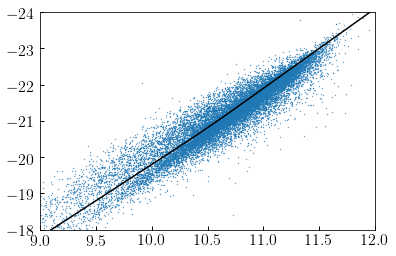

In [120]:
fig, ax = plt.subplots(1, 1)

nskip = 10
__=ax.scatter(sdss['sm'][::nskip], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip],
             s=0.1)

mstararr = np.linspace(9, 12, 10)
m1 = 10.5
magr_at_m1_z0 = -20.8
gamma = 2
beta = 2.2
y = magr(10**mstararr, upid, m1, magr_at_m1_z0, gamma, beta, dm1=0.15)
__=ax.plot(mstararr, y, color='k')
xlim = ax.set_xlim(9, 12)
ylim = ax.set_ylim(-18, -24)

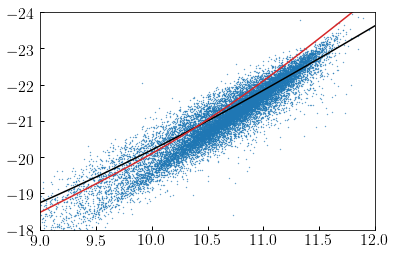

In [92]:
fig, ax = plt.subplots(1, 1)

nskip = 10
__=ax.scatter(sdss['sm'][::nskip], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip],
             s=0.1)

mstararr = np.linspace(9, 12, 100)
y = median_magr_from_mstar(10**mstararr, np.zeros(100)-1, 0.0)
__=ax.plot(mstararr, y, color='k')

y2 = median_magr_from_mstar(10**mstararr, np.zeros(100)-1, 0.0, **kwargs_alt2)
__=ax.plot(mstararr, y2, color=mred)

xlim = ax.set_xlim(9, 12)
ylim = ax.set_ylim(-18, -24)

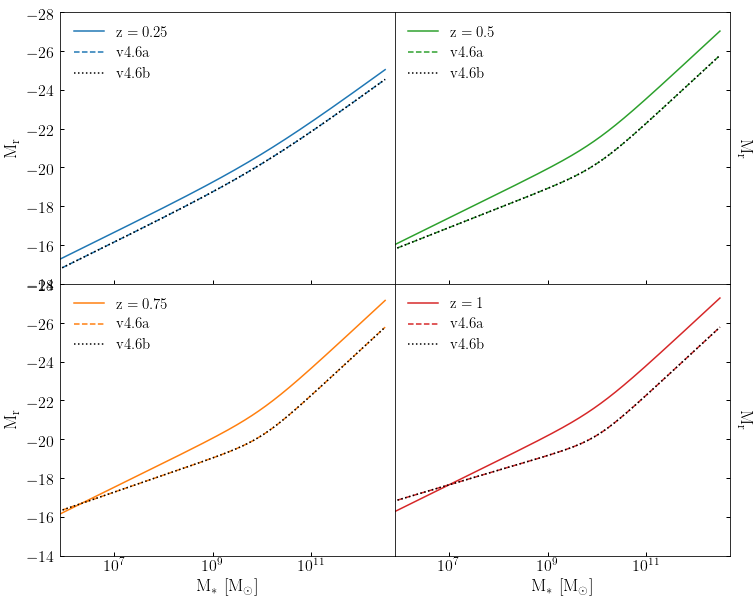

In [34]:
fig, _axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

ax2.yaxis.set_label_position("right")  #  y-labels on the right
ax2.yaxis.tick_right()  #  y-ticks on the right
ax4.yaxis.set_label_position("right")  #  y-labels on the right
ax4.yaxis.tick_right()  #  y-ticks on the right

for ax in axes:
    xscale = ax.set_xscale('log')
    ylim = ax.set_ylim(-14, -28)
    xlim = ax.set_xlim(8e5, 5e12)

    
__=ax1.plot(mstar, mr_z0p25, color=mblue, label=r'${\rm z=0.25}$')
__=ax1.plot(mstar, mr_z0p25_alt, '--', color=mblue, label=r'${\rm v4.6a}$')
__=ax1.plot(mstar, mr_z0p25_alt2, ':', color='k', label=r'${\rm v4.6b}$')

__=ax2.plot(mstar, mr_z0p5, color=mgreen, label=r'${\rm z=0.5}$')
__=ax2.plot(mstar, mr_z0p5_alt, '--', color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(mstar, mr_z0p5_alt2, ':', color='k', label=r'${\rm v4.6b}$')

__=ax3.plot(mstar, mr_z0p75, color=morange, label=r'${\rm z=0.75}$')
__=ax3.plot(mstar, mr_z0p75_alt, '--', color=morange, label=r'${\rm v4.6a}$')
__=ax3.plot(mstar, mr_z0p75_alt2, ':', color='k', label=r'${\rm v4.6b}$')

__=ax4.plot(mstar, mr_z1p0, color=mred, label=r'${\rm z=1}$')
__=ax4.plot(mstar, mr_z1p0_alt, '--', color=mred, label=r'${\rm v4.6a}$')
__=ax4.plot(mstar, mr_z1p0_alt2, ':', color='k', label=r'${\rm v4.6b}$')

    
for ax in axes:
    leg = ax.legend()
    
xlabel3 = ax3.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
xlabel4 = ax4.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
ylabel1 = ax1.set_ylabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm M_{r}}$', rotation=-90, labelpad=20)
ylabel3 = ax3.set_ylabel(r'${\rm M_{r}}$')
ylabel4 = ax4.set_ylabel(r'${\rm M_{r}}$', rotation=-90, labelpad=20)

# figname = 'four_panel_mr_mstar_comparison_v4p5_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

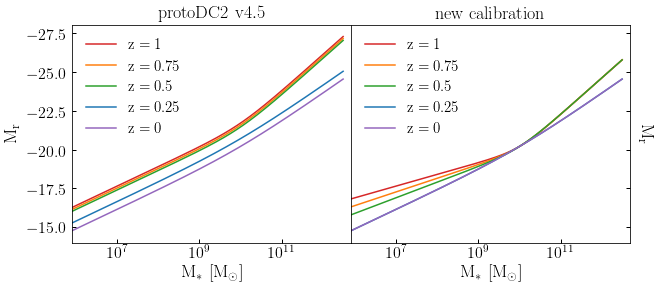

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
# fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots
ax2.yaxis.set_label_position("right")  #  y-labels on the right
ax2.yaxis.tick_right()  #  y-ticks on the right
#  To turn off tick labels but keep the tick::
# ax2.set_yticklabels([''])

for ax in (ax1, ax2):
    xscale = ax.set_xscale('log')

__=ax1.plot(mstar, mr_z1p0, color=mred, label=r'${\rm z=1}$')
__=ax1.plot(mstar, mr_z0p75, color=morange, label=r'${\rm z=0.75}$')
__=ax1.plot(mstar, mr_z0p5, color=mgreen, label=r'${\rm z=0.5}$')
__=ax1.plot(mstar, mr_z0p25, color=mblue, label=r'${\rm z=0.25}$')
__=ax1.plot(mstar, mr_z0p0, color=mpurple, label=r'${\rm z=0}$')

__=ax2.plot(mstar, mr_z1p0_alt, color=mred, label=r'${\rm z=1}$')
__=ax2.plot(mstar, mr_z0p75_alt, color=morange, label=r'${\rm z=0.75}$')
__=ax2.plot(mstar, mr_z0p5_alt, color=mgreen, label=r'${\rm z=0.5}$')
__=ax2.plot(mstar, mr_z0p25_alt, color=mblue, label=r'${\rm z=0.25}$')
__=ax2.plot(mstar, mr_z0p0_alt, color=mpurple, label=r'${\rm z=0}$')

ylim1 = ax1.set_ylim(-14, -28)
xlim1 = ax1.set_xlim(8e5, 5e12)

legend = ax1.legend()
legend2 = ax2.legend()
title1 = ax1.set_title(r'${\rm protoDC2\ v4.5}$')
title2 = ax2.set_title(r'${\rm new\ calibration}$')

xlabel = ax1.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
ylabel = ax1.set_ylabel(r'${\rm M_{r}}$')
xlabel = ax2.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
ylabel = ax2.set_ylabel(r'${\rm M_{r}}$', rotation=-90, labelpad=20)

# figname = 'two_panel_mr_mstar_comparison_v4p5_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Resample low-mass galaxies to boost the dwarf galaxy SMF


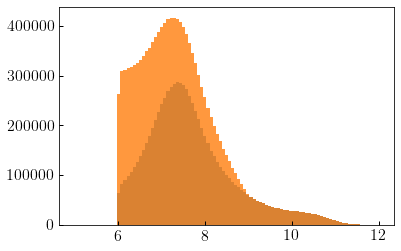

In [36]:
from scipy.stats import powerlaw
num_new_gals = int(5e6)
fake_mstar = 10**((1 - powerlaw.rvs(2, size=num_new_gals))*3 + 6)

mock_mask = mock['mstar'] < 10**7
num_cutmock = np.count_nonzero(mock_mask)

fake_galaxies = Table()
for key in mock.keys():
    fake_galaxies[key] = np.zeros(num_new_gals)
fake_galaxies['mstar'] = fake_mstar
fake_galaxies['upid'] = -1

_a = np.arange(num_cutmock)
idx = np.random.choice(_a, replace=True, size=num_new_gals)

fake_galaxies['redshift'] = mock['redshift'][mock_mask][idx]
fake_galaxies['mag_r_kcorrect'] = mock['mag_r_kcorrect'][mock_mask][idx]

from astropy.table import vstack
newmock = vstack((mock, fake_galaxies))

fig, ax = plt.subplots(1, 1)

logsm_bins = np.linspace(5, 12, 100)

__=ax.hist(np.log10(mock['mstar']), bins=logsm_bins, alpha=0.8)
__=ax.hist(np.log10(newmock['mstar']), bins=logsm_bins, alpha=0.8)

In [37]:
# newmock = Table(np.copy(mock))


### Reassign r-band magnitude to new mock


In [38]:

scatter_magr = 0.25

new_median_magr = median_magr_from_mstar(
    newmock['mstar'], newmock['upid'], newmock['redshift'], **kwargs_alt)
newmock['mag_r'] = np.random.normal(loc=new_median_magr, scale=scatter_magr) 
newmock['mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['mag_r']



In [39]:
new_median_magr2 = median_magr_from_mstar(
    newmock['mstar'], newmock['upid'], newmock['redshift'], **kwargs_alt2)

newmock['new_mag_r'] = np.random.normal(loc=new_median_magr2, scale=scatter_magr) 
newmock['new_mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['new_mag_r']


## Resample low-mass galaxies to boost the dwarf galaxy SMF

In [40]:
# from cosmodc2.sdss_colors.resample_lowmass_galaxies import new_faint_galaxies

# num_new = int(2e6)
# idx = new_faint_galaxies(mock['mstar'], num_new,
#                         fakegals_logsm_table=[6, 6.5, 7, 7.3, 7.5],
#                         fakegals_prob_table=[15., 7.5, 3., 1.5, 0.])

# fake_galaxies = mock[idx]
# fake_galaxies['real'] = False
# fake_galaxies['mstar'] = 10**np.random.normal(
#     loc=np.log10(fake_galaxies['mstar']), scale=0.001)

# from cosmodc2.sdss_colors.resample_lowmass_galaxies import remove_middling_galaxies
# num_to_remove = int(3e6)
# cutmask = remove_middling_galaxies(mock['mstar'], num_to_remove)

# from astropy.table import vstack
# newmock = vstack((mock[cutmask], fake_galaxies))

# fig, ax = plt.subplots(1, 1)
# yscale = ax.set_yscale('log')
# logsm_bins = np.linspace(6, 12.5, 50)
# logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

# counts_orig, __ = np.histogram(np.log10(mock['mstar']), bins=logsm_bins)
# counts_new, __ = np.histogram(np.log10(newmock['mstar']), bins=logsm_bins)

# __=ax.errorbar(logsm_mids, counts_orig, 0.5*counts_orig, 
#                fmt='.', color=mred, label=r'${\rm v4.5}$')
# __=ax.errorbar(logsm_mids, counts_new, 0.5*counts_new, 
#                fmt='.', color=mgreen, label=r'${\rm v4.6}$')

# xlim = ax.set_xlim(5.85, 12.5)
# xlabel = ax.set_xlabel(r'${\rm logM_{\ast}}$')
# ylabel = ax.set_ylabel(r'${\rm counts}$')
# legend = ax.legend()

# figname = 'hsc_dndmagr_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [41]:
# from cosmodc2.sdss_colors.resample_lowmass_galaxies import new_faint_galaxies

# num_new = int(2e6)
# idx = new_faint_galaxies(mock['mstar'], num_new,
#                         fakegals_logsm_table=[6, 6.5, 7, 7.3, 7.5],
#                         fakegals_prob_table=[15., 7.5, 3., 1.5, 0.])

# fake_galaxies = mock[idx]
# fake_galaxies['real'] = False
# fake_galaxies['mstar'] = 10**np.random.normal(
#     loc=np.log10(fake_galaxies['mstar']), scale=0.001)

# from cosmodc2.sdss_colors.resample_lowmass_galaxies import remove_middling_galaxies
# num_to_remove = int(3e6)
# cutmask = remove_middling_galaxies(mock['mstar'], num_to_remove)

# from astropy.table import vstack
# newmock = vstack((mock[cutmask], fake_galaxies))

# newmock = mock

# logsm_bins = np.linspace(6, 12.5, 50)
# logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

# counts_orig, __ = np.histogram(np.log10(mock['mstar']), bins=logsm_bins)
# counts_new, __ = np.histogram(np.log10(newmock['mstar']), bins=logsm_bins)


In [42]:
# fig, ax = plt.subplots(1, 1)
# yscale = ax.set_yscale('log')

# __=ax.errorbar(logsm_mids, counts_orig, 0.5*counts_orig, 
#                fmt='.', color=mred, label=r'${\rm v4.5}$')
# __=ax.errorbar(logsm_mids, counts_new, 0.5*counts_new, 
#                fmt='.', color=mgreen, label=r'${\rm v4.6}$')

# xlim = ax.set_xlim(5.85, 12.5)
# xlabel = ax.set_xlabel(r'${\rm logM_{\ast}}$')
# ylabel = ax.set_ylabel(r'${\rm counts}$')
# legend = ax.legend()

# figname = 'hsc_dndmagr_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## HSC dn/dmag tests

In [43]:
def dndmag(observed_flux, flux_bins=np.linspace(22, 28.5, 50), sky_area=25.):
    counts = np.array([np.count_nonzero(observed_flux < x) for x in flux_bins])
    return counts/float(sky_area), flux_bins


In [44]:
print(newmock.keys())

['redshift', 'mstar', 'mag_r', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'upid', 'mag_r_kcorrect', 'new_mag_r', 'new_mag_r_obs']


In [45]:
dndmag_v4p5, magr_obs_bins = dndmag(mock['mag_r_obs'])
dndmag_v4p6a, magr_obs_bins = dndmag(newmock['mag_r_obs'])
dndmag_v4p6b, magr_obs_bins = dndmag(newmock['new_mag_r_obs'])

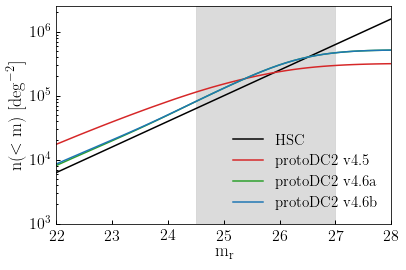

In [46]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
x1 = np.zeros(100) + 24.5
x2 = np.zeros(100) + 27
y = np.logspace(1, 10, 100)

__=ax.fill_betweenx(y, x1, x2, alpha=0.8, color='lightgray')

c0_hsc_r, c1_hsc_r = -5, 0.4
hsc_dndmagr_abscissa = np.linspace(20, 30, 100)
hsc_dndmagr_ordinates = 10**(c0_hsc_r + c1_hsc_r*hsc_dndmagr_abscissa)
__=ax.plot(hsc_dndmagr_abscissa, hsc_dndmagr_ordinates, label=r'${\rm HSC}$', color='k')

__=ax.plot(magr_obs_bins, dndmag_v4p5, label=r'${\rm protoDC2\ v4.5}$', color=mred)
__=ax.plot(magr_obs_bins, dndmag_v4p6a, label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax.plot(magr_obs_bins, dndmag_v4p6b, label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

xlabel = ax.set_xlabel(r'${\rm m_{r}}$')
ylabel = ax.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend = ax.legend()
ylim = ax.set_ylim(1e3, 2.5e6)
xlim = ax.set_xlim(22, 28)

# figname = 'hsc_dndmagr_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

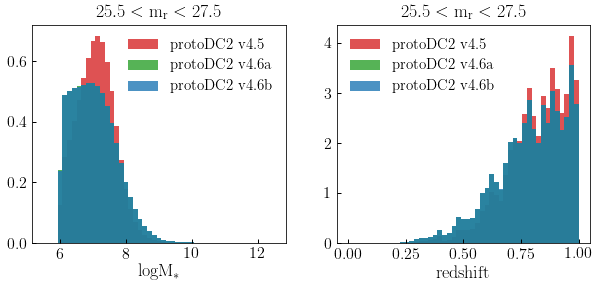

In [47]:
faint, bright = 27.5, 25.5


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

logsm_bins = np.linspace(5.5, 12.5, 50)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

magr_mask = mock['mag_r_obs'] > bright
magr_mask *= mock['mag_r_obs'] < faint
__=ax1.hist(np.log10(mock['mstar'][magr_mask]), bins=logsm_bins, normed=True, 
          alpha=0.8, color=mred, label=r'${\rm protoDC2\ v4.5}$')
magr_mask = newmock['mag_r_obs'] > bright
magr_mask *= newmock['mag_r_obs'] < faint
__=ax1.hist(np.log10(newmock['mstar'][magr_mask]), bins=logsm_bins, normed=True, 
          alpha=0.8, color=mgreen, label=r'${\rm protoDC2\ v4.6a}$')
magr_mask = newmock['new_mag_r_obs'] > bright
magr_mask *= newmock['new_mag_r_obs'] < faint
__=ax1.hist(np.log10(newmock['mstar'][magr_mask]), bins=logsm_bins, normed=True, 
          alpha=0.8, color=mblue, label=r'${\rm protoDC2\ v4.6b}$')


zbins = np.linspace(0, 1, 50)

magr_mask = mock['mag_r_obs'] > bright
magr_mask *= mock['mag_r_obs'] < faint
__=ax2.hist(mock['redshift'][magr_mask], bins=zbins, normed=True, 
          alpha=0.8, color=mred, label=r'${\rm protoDC2\ v4.5}$')
magr_mask = newmock['mag_r_obs'] > bright
magr_mask *= newmock['mag_r_obs'] < faint
__=ax2.hist(newmock['redshift'][magr_mask], bins=zbins, normed=True, 
          alpha=0.8, color=mgreen, label=r'${\rm protoDC2\ v4.6a}$')

magr_mask = newmock['new_mag_r_obs'] > bright
magr_mask *= newmock['new_mag_r_obs'] < faint
__=ax2.hist(newmock['redshift'][magr_mask], bins=zbins, normed=True, 
          alpha=0.8, color=mblue, label=r'${\rm protoDC2\ v4.6b}$')


xlabel1 = ax1.set_xlabel(r'${\rm logM_{\ast}}$')
xlabel2 = ax2.set_xlabel(r'${\rm redshift}$')

title1 = ax1.set_title(r'${\rm 25.5 < m_{r} < 27.5}$')
title2 = ax2.set_title(r'${\rm 25.5 < m_{r} < 27.5}$')

leg1 = ax1.legend()
leg2 = ax2.legend()

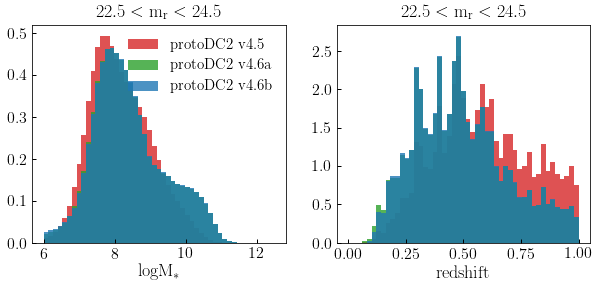

In [48]:
faint, bright = 24.5, 22.5


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

logsm_bins = np.linspace(6, 12.5, 50)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

magr_mask = mock['mag_r_obs'] > bright
magr_mask *= mock['mag_r_obs'] < faint
__=ax1.hist(np.log10(mock['mstar'][magr_mask]), bins=logsm_bins, normed=True, 
          alpha=0.8, color=mred, label=r'${\rm protoDC2\ v4.5}$')
magr_mask = newmock['mag_r_obs'] > bright
magr_mask *= newmock['mag_r_obs'] < faint
__=ax1.hist(np.log10(newmock['mstar'][magr_mask]), bins=logsm_bins, normed=True, 
          alpha=0.8, color=mgreen, label=r'${\rm protoDC2\ v4.6a}$')
magr_mask = newmock['new_mag_r_obs'] > bright
magr_mask *= newmock['new_mag_r_obs'] < faint
__=ax1.hist(np.log10(newmock['mstar'][magr_mask]), bins=logsm_bins, normed=True, 
          alpha=0.8, color=mblue, label=r'${\rm protoDC2\ v4.6b}$')


zbins = np.linspace(0, 1, 50)

magr_mask = mock['mag_r_obs'] > bright
magr_mask *= mock['mag_r_obs'] < faint
__=ax2.hist(mock['redshift'][magr_mask], bins=zbins, normed=True, 
          alpha=0.8, color=mred, label=r'${\rm protoDC2\ v4.5}$')
magr_mask = newmock['mag_r_obs'] > bright
magr_mask *= newmock['mag_r_obs'] < faint
__=ax2.hist(newmock['redshift'][magr_mask], bins=zbins, normed=True, 
          alpha=0.8, color=mgreen, label=r'${\rm protoDC2\ v4.6a}$')

magr_mask = newmock['new_mag_r_obs'] > bright
magr_mask *= newmock['new_mag_r_obs'] < faint
__=ax2.hist(newmock['redshift'][magr_mask], bins=zbins, normed=True, 
          alpha=0.8, color=mblue, label=r'${\rm protoDC2\ v4.6b}$')


xlabel1 = ax1.set_xlabel(r'${\rm logM_{\ast}}$')
xlabel2 = ax2.set_xlabel(r'${\rm redshift}$')

title1 = ax1.set_title(r'${\rm 22.5 < m_{r} < 24.5}$')
title2 = ax2.set_title(r'${\rm 22.5 < m_{r} < 24.5}$')

leg1 = ax1.legend()
# leg2 = ax2.legend()

## DEEP2 dn/dz tests

In [49]:
import os
deep2_dirname = "/Users/aphearin/work/repositories/python/cosmodc2/cosmodc2/data"

X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_22.txt"))
deep2_dndz_r22_redshift, deep2_dndz_r22_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_23.txt"))
deep2_dndz_r23_redshift, deep2_dndz_r23_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_24.txt"))
deep2_dndz_r24_redshift, deep2_dndz_r24_fit = X[:, 0], X[:, 1]

In [50]:
redshift_bins = np.linspace(0, 1, 15)
redshift_mids = 0.5*(redshift_bins[:-1] + redshift_bins[1:])

mask22 = mock['mag_r_obs'] < 22
mask23 = mock['mag_r_obs'] < 23
mask24 = mock['mag_r_obs'] < 24

pdc2_v4p5_dndz_r22, __ = np.histogram(
    mock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r23, __ = np.histogram(
    mock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r24, __ = np.histogram(
    mock['redshift'][mask24], density=True, bins=redshift_bins)


mask22 = newmock['mag_r_obs'] < 22
mask23 = newmock['mag_r_obs'] < 23
mask24 = newmock['mag_r_obs'] < 24

pdc2_v4p6a_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)

mask22 = newmock['new_mag_r_obs'] < 22
mask23 = newmock['new_mag_r_obs'] < 23
mask24 = newmock['new_mag_r_obs'] < 24

pdc2_v4p6b_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)


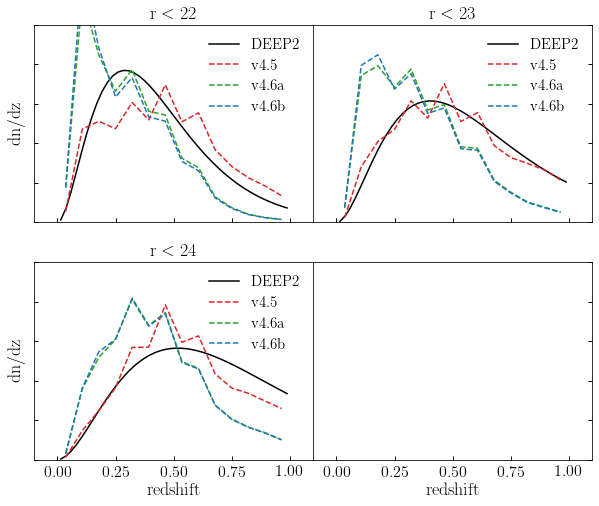

In [51]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
# fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots
__=ax2.yaxis.set_label_position("right")  #  y-labels on the right
__=ax4.yaxis.set_label_position("right")  #  y-labels on the right
__=ax2.yaxis.tick_right()  #  y-ticks on the right
__=ax4.yaxis.tick_right()  #  y-ticks on the right
__=ax2.set_yticklabels([''])
__=ax4.set_yticklabels([''])
         
    
__=ax1.plot(deep2_dndz_r22_redshift, deep2_dndz_r22_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax1.plot(redshift_mids, pdc2_v4p5_dndz_r22, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax1.plot(redshift_mids, pdc2_v4p6a_dndz_r22, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax1.plot(redshift_mids, pdc2_v4p6b_dndz_r22, '--', 
           color=mblue, label=r'${\rm v4.6b}$')



__=ax2.plot(deep2_dndz_r23_redshift, deep2_dndz_r23_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax2.plot(redshift_mids, pdc2_v4p5_dndz_r23, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax2.plot(redshift_mids, pdc2_v4p6a_dndz_r23, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(redshift_mids, pdc2_v4p6b_dndz_r23, '--', 
           color=mblue, label=r'${\rm v4.6b}$')

__=ax3.plot(deep2_dndz_r24_redshift, deep2_dndz_r24_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax3.plot(redshift_mids, pdc2_v4p5_dndz_r24, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax3.plot(redshift_mids, pdc2_v4p6a_dndz_r24, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax3.plot(redshift_mids, pdc2_v4p6b_dndz_r24, '--', 
           color=mblue, label=r'${\rm v4.6b}$')

xlabel3 = ax3.set_xlabel(r'${\rm redshift}$')
xlabel4 = ax4.set_xlabel(r'${\rm redshift}$')
ylabel1 = ax1.set_ylabel(r'${\rm dn/dz}$')
ylabel3 = ax3.set_ylabel(r'${\rm dn/dz}$')

xlim = ax1.set_xlim(-0.1, 1.1)
ylim = ax1.set_ylim(0, 2.5)

legend1 = ax1.legend()
legend2 = ax2.legend()
legend3 = ax3.legend()


title1 = ax1.set_title(r'${\rm r < 22}$')
title2 = ax2.set_title(r'${\rm r < 23}$')
title3 = ax3.set_title(r'${\rm r < 24}$')

# figname = 'deep2_dndz_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Luminosity function in CMASS range

In [52]:
def cmass_selection_mask(g, r, i):
    d_perp = (r-i) - (g-r)/8.
    mask = d_perp > 0.55
    mask *= (i < (19.86 + 1.6*(d_perp - 0.8)))
    mask *= (i > 17.5)
    mask *= (i < 19.9)
    mask *= (r-i < 2)
    return mask

pdc2_v4p5_sky_area = 25.

cmass_mask = cmass_selection_mask(mock['mag_g_obs'], mock['mag_r_obs'], mock['mag_i_obs'])
num_pdc2_v4p5_cmass_galaxies = np.count_nonzero(cmass_mask)
pdc2_v4p5_cmass_number_density = num_pdc2_v4p5_cmass_galaxies/float(pdc2_v4p5_sky_area)

# cmass_mask = cmass_selection_mask(
#     newmock['mag_g_obs'], newmock['mag_r_obs'], newmock['mag_i_obs'])
# num_pdc2_v4p5_cmass_galaxies = np.count_nonzero(cmass_mask)
# pdc2_v4p5_cmass_number_density = num_pdc2_v4p5_cmass_galaxies/float(pdc2_v4p5_sky_area)

print("CMASS number density in protoDC2 v4.5 = {0:.2f}/deg^2".format(
    pdc2_v4p5_cmass_number_density))
# print("CMASS number density in protoDC2 v4.6a = {0:.2f}/deg^2".format(
#     pdc2_v4p5_cmass_number_density))
# print("CMASS number density in protoDC2 v4.6b = {0:.2f}/deg^2".format(
#     pdc2_v4p5_cmass_number_density))
print("Observed CMASS number density = {0:.2f}/deg^2".format(101))


CMASS number density in protoDC2 v4.5 = 645.52/deg^2
Observed CMASS number density = 101.00/deg^2


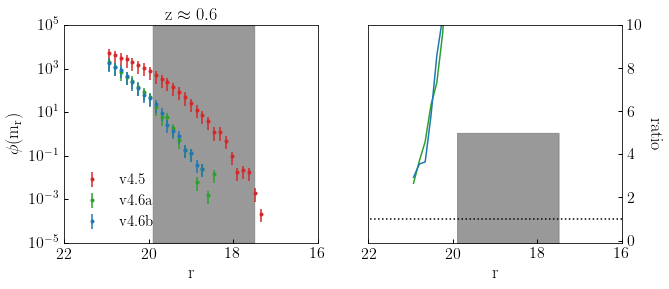

In [53]:
zmask_0p6 = mock['redshift'] > 0.5
zmask_0p6 *= mock['redshift'] < 0.65

magr_bins = np.linspace(17, 21, 30)
magr_mids = 0.5*(magr_bins[:-1] + magr_bins[1:])

normed_counts, __ = np.histogram(mock['mag_r_obs'][zmask_0p6], bins=magr_bins, density=True)
counts, __ = np.histogram(mock['mag_r_obs'][zmask_0p6], bins=magr_bins, density=False)
pdf_v4p5 = counts*normed_counts

zmask_0p6_v4p6 = newmock['redshift'] > 0.5
zmask_0p6_v4p6 *= newmock['redshift'] < 0.65

normed_counts_v4p6a, __ = np.histogram(
    newmock['mag_r_obs'][zmask_0p6_v4p6], bins=magr_bins, density=True)
counts_v4p6a, __ = np.histogram(
    newmock['mag_r_obs'][zmask_0p6_v4p6], bins=magr_bins, density=False)
pdf_v4p6a = counts_v4p6a*normed_counts_v4p6a

normed_counts_v4p6b, __ = np.histogram(
    newmock['new_mag_r_obs'][zmask_0p6_v4p6], bins=magr_bins, density=True)
counts_v4p6b, __ = np.histogram(
    newmock['new_mag_r_obs'][zmask_0p6_v4p6], bins=magr_bins, density=False)
pdf_v4p6b = counts_v4p6b*normed_counts_v4p6b


fracdiff_v4p6a = (pdf_v4p5 - pdf_v4p6a)/pdf_v4p5
fracdiff_v4p6b = (pdf_v4p5 - pdf_v4p6b)/pdf_v4p5
ratio_v4p6a = (pdf_v4p6a)/pdf_v4p5
ratio_v4p6b = (pdf_v4p6b)/pdf_v4p5


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
__=ax2.yaxis.set_label_position("right")  #  y-labels on the right
__=ax2.yaxis.tick_right()  #  y-ticks on the right
# __=ax2.set_yticklabels([''])

yscale = ax1.set_yscale('log')
__=ax1.errorbar(magr_mids, pdf_v4p5, 0.6*pdf_v4p5, 
               fmt='.', color=mred, label=r'${\rm v4.5}$')
__=ax1.errorbar(magr_mids, pdf_v4p6a, 0.6*pdf_v4p6a, 
               fmt='.', color=mgreen, label=r'${\rm v4.6a}$')
__=ax1.errorbar(magr_mids, pdf_v4p6b, 0.6*pdf_v4p6b, 
               fmt='.', color=mblue, label=r'${\rm v4.6b}$')


npts = 1000
x1 = np.zeros(npts) + 17.5
x2 = np.zeros(npts) + 19.9
y = np.logspace(-5, 5, npts)
__=ax1.fill_betweenx(y, x1, x2, alpha=0.8, color='gray')

xlim = ax1.set_xlim(22, 16)
ylim = ax1.set_ylim(1e-5, 1e5)
legend = ax1.legend(loc='lower left')

xlabel = ax1.set_xlabel(r'${\rm r}$')
ylabel = ax1.set_ylabel(r'$\phi({\rm m_r})$')
title = ax1.set_title(r'${\rm z \approx 0.6}$')


_mask1 = (ratio_v4p6a > 0) & (~np.isnan(ratio_v4p6a>0))
_mask2 = (ratio_v4p6b > 0) & (~np.isnan(ratio_v4p6b>0))
__=ax2.plot(magr_mids[_mask1], 1./ratio_v4p6a[_mask1], 
            color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(magr_mids[_mask2], 1./ratio_v4p6b[_mask2], 
            color=mblue, label=r'${\rm v4.6b}$')

xmin, xmax = 16, 22

__=ax2.plot(np.linspace(xmin, xmax, 100), np.ones(100),  ':', color='k')

npts = 1000
x1 = np.zeros(npts) + 17.5
x2 = np.zeros(npts) + 19.9
y = np.linspace(-5, 5, npts)
__=ax2.fill_betweenx(y, x1, x2, alpha=0.8, color='gray')
ylim = ax2.set_ylim(-0.1, 10)

xlabel2 = ax2.set_xlabel(r'${\rm r}$')
ylabel2 = ax2.set_ylabel(r'${\rm ratio}$', rotation=-90, labelpad=20)

# figname = 'cmass_luminosity_function_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [54]:
# zmask_0p6 = mock['redshift'] > 0.5
# zmask_0p6 *= mock['redshift'] < 0.65
# magr_mask = mock['mag_r_obs'] > 17.5
# magr_mask *= mock['mag_r_obs'] < 19.9

# fig, ax = plt.subplots(1, 1)

# __=ax.hist(np.log10(mock['mstar'][magr_mask & zmask_0p6]), bins=40, normed=True, 
#            alpha=0.8, label=r'${\rm protoDC2\ v4.5}')
# legend = ax.legend()
# xlabel = ax.set_xlabel(r'${\rm logM_{\ast}}$')
# ylabel = ax.set_ylabel(r'${\rm PDF}$')
# title = ax.set_title(r'${\rm z \approx 0.6; 17.5 < m_{r} < 19.9}$')
